Реализация PINN на pytorch взята отсюда: https://github.com/jayroxis/PINNs/blob/master/Burgers%20Equation/Burgers%20Inference%20(PyTorch).ipynb

#PINN

коэффициенты

In [25]:
coeff_a = 1

решение

In [26]:
!pip install pyDOE

In [27]:
import math
import torch
import matplotlib.pyplot as plt
from collections import OrderedDict #упорядоченный словарь
from pyDOE import lhs #функция, выбирающая значения для обучения на них нейросети
import numpy as np
import time
#plt.rcParams['figure.dpi'] = 150 #высокое качество графиков
np.random.seed(1234)

In [28]:
#можно сменить среду выполнения на gpu и обучение будет происходить быстрее
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [29]:
class SinActivation(torch.nn.Module): #кастомная функция активации - sin
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)

нейросеть, в виде которой будет находиться решение

In [30]:
class DNN(torch.nn.Module):
    def __init__(self, layers): #принимает на вход массив целых чисел
        super(DNN, self).__init__() #вызывает метод init(почему нельзя сделать это без super?)

        self.depth = len(layers) - 1
        self.activation = SinActivation #в качестве функции активации используется sin

        layer_list = list() #список с весами и функциями активации для каждого слоя
        for i in range(self.depth - 1):
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])) #каждые два слоя образуют двудольный граф
            )
            layer_list.append(('activation_%d' % i, self.activation()))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])) #нельзя сделать в цикле, потому что нет функции активации
        )

        layerDict = OrderedDict(layer_list) #сделали упорядоченный словарь, чтобы при использовании элементы выдавались в том порядке, в котором были добавлены

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict) #собственно, задали архитектуру нейросети

    def forward(self, x):
        out = self.layers(x)
        return out

наконец, PINN

In [31]:
class PhysicsInformedNN():
    def __init__(self, X_ic, u_ic, X_e, layers, lb, ub, coeff_a):

        # границы области
        self.lb = torch.tensor(lb).float().to(device) #левая нижняя
        self.ub = torch.tensor(ub).float().to(device) #правая верхняя

        # данные для обучения
        self.x_ic = torch.tensor(X_ic[:, 0:1], requires_grad=True).float().to(device) #для начальных условий: (x_ic, y_ic, t_ic, u_ic)
        self.y_ic = torch.tensor(X_ic[:, 1:2], requires_grad=True).float().to(device)
        self.t_ic = torch.tensor(X_ic[:, 2:3], requires_grad=True).float().to(device)
        self.u_ic = torch.tensor(u_ic).float().to(device)
        self.x_e = torch.tensor(X_e[:, 0:1], requires_grad=True).float().to(device) #для граничных условий: (x_e, y_e, t_e)
        self.y_e = torch.tensor(X_e[:, 1:2], requires_grad=True).float().to(device)
        self.t_e = torch.tensor(X_e[:, 2:3], requires_grad=True).float().to(device)
        self.x_f = torch.tensor((lb + (ub-lb)*lhs(3, N_f))[:, 0:1], requires_grad=True).float().to(device) #создаём N_f точек для обучения соответствия уравнению. те, что переданы, не используем
        self.y_f = torch.tensor((lb + (ub-lb)*lhs(3, N_f))[:, 1:2], requires_grad=True).float().to(device)
        self.t_f = torch.tensor((lb + (ub-lb)*lhs(3, N_f))[:, 2:3], requires_grad=True).float().to(device)

        # числовые коэффициенты в уравнении
        self.a = coeff_a

        # модель
        self.layers = layers
        self.dnn = DNN(layers).to(device)

        # оптимизатор - LBFGS, обучает с точностью до 1e-5 или пока разница в точности уменьшается больше, чем точность float(?)
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.0001,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            #line_search_fn="strong_wolfe"
        )

        self.adam = torch.optim.Adam(
          self.dnn.parameters(),
          lr=0.005,
          betas=(0.9, 0.999),
          eps=1e-08,
          weight_decay=0,
          amsgrad=False)

        self.iter = 0

    def net_u(self, x, y, t): # вывод модели
        u = self.dnn(torch.cat([x, y, t], dim=1))
        return u

    def net_u_res(self, x, y, t): #вывод  функции
        u = self.net_u(x, y, t)
        f = g(x, y, t)

        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0] #производная по t
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0] #производная по x
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0] #вторая призводная по x
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0] #производная по y
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True)[0] #вторая призводная по y

        u_res = u_t - self.a**2 * (u_xx+u_yy) - f
        return u_res

    def loss_func(self): #функция потерь
        self.optimizer.zero_grad() #обнуляет градиенты

        u_pred_ic = self.net_u(self.x_ic, self.y_ic, self.t_ic)
        u_pred_le = self.net_u(self.x_e, self.y_e, self.t_e)[0:t_parts*y_parts,:].reshape(y_parts,t_parts)
        u_pred_re = self.net_u(self.x_e, self.y_e, self.t_e)[t_parts*y_parts:2*t_parts*y_parts,:].reshape(y_parts,t_parts)
        f_pred = self.net_u_res(self.x_f, self.y_f, self.t_f)
        loss_ic = torch.mean((self.u_ic - u_pred_ic) ** 2) #средний квадрат всех отклонений от начальных условий
        loss_f = torch.mean(f_pred ** 2) #средний квадрат всех отклонений от условия
        loss_e = torch.mean((u_pred_le - torch.flip(u_pred_re,[0]))**2) #средний квадрат разности граничных условий(одно из них повёрнуто)

        loss = loss_ic + loss_f + loss_e

        loss.backward()
        self.iter += 1
        if self.iter % 1000 == 0:
            print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_f: %.5e, Loss_e: %.5e' % (self.iter, loss.item(), loss_ic.item(), loss_f.item(), loss_e.item()))
            loss_array.append(loss.item()) #loss запоминаем для графика
            loss_ic_array.append(loss_ic.item()) #loss_ic, loss_f и loss_e тоже
            loss_f_array.append(loss_f.item())
            loss_e_array.append(loss_e.item())
            iter_array.append(self.iter)

        if self.iter % 10 == 0: #каждые 10 итераций генерируем новые точки для обучения
          random_points = lb + (ub-lb)*lhs(3, N_f)
          self.x_f = torch.tensor(random_points[:, 0:1], requires_grad=True).float().to(device)
          self.y_f = torch.tensor(random_points[:, 1:2], requires_grad=True).float().to(device)
          self.t_f = torch.tensor(random_points[:, 2:3], requires_grad=True).float().to(device)

        return loss

    def train(self): #обучение
        adam_iterations = 50000
        print('training started')
        print('%d iterations of ADAM:' %adam_iterations)
        self.dnn.train()
        for i in range(adam_iterations): #во время тренировки производится 50000 шагов adam
            if i % 100 == 0: self.adam.param_groups[0]['lr'] = 0.99*self.adam.param_groups[0]['lr'] #экспоненциальное уменьшение шага каждые 100 шагов
            self.adam.step(self.loss_func)
        print('LBFGS:') #а дальше запускается lbfgs
        self.optimizer.step(self.loss_func)
        print('Total iterations: %d + %d' %(adam_iterations, (self.iter-adam_iterations)))


    def predict(self, X): #вывод нейросети и функции на входных данных
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 2:3], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, y, t)
        f = self.net_u_res(x, y, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

параметры обучения

In [32]:
N_ic = 1000 # число точек, обучающих принимать начальные условия
N_f = 30000 # число точек, обучающих удовлетворять уравнению
x_parts = 100 #число частей, на которые разбивается отрезок x
y_parts = 60 #число частей, на которые разбивается отрезок y
t_parts = 50 #число частей, на которые разбивается отрезок t
layers = [3, 30, 30, 30, 1] #3 входа, 1 выход и 3 слоя по 30 нейронов

x_0=0
x_1=2*math.pi
y_0=-1
y_1=1
t_0=0
t_1=1
x = np.linspace(x_0, x_1, x_parts)
y = np.linspace(y_0, y_1, y_parts)
t = np.linspace(t_0, t_1, t_parts)
X, Y, T = np.meshgrid(x, y, t)

In [33]:
#опыт 4
def u(x,y,t): #начальное условие
  u=0*x
  return u
def g(x,y,t): #второе слагаемое в правой части уравнения
  g=5*torch.exp(-3*(x-1-2*(math.pi-1)*t)**2 - 5*(y+1-2*t)**2)
  return g

In [34]:
'''#опыт 4
def u(x,y,t): #начальное условие
  u=0*x
  return u
def g(x,y,t): #второе слагаемое в правой части уравнения
  g=5*torch.exp(-5*torch.sin(0.5*x-math.pi*t)**2 - 10*torch.sin(0.5*math.pi*(y+1)-math.pi*t)**2)
  return g'''

'#опыт 4\ndef u(x,y,t): #начальное условие\n  u=0*x\n  return u\ndef g(x,y,t): #второе слагаемое в правой части уравнения\n  g=5*torch.exp(-5*torch.sin(0.5*x-math.pi*t)**2 - 10*torch.sin(0.5*math.pi*(y+1)-math.pi*t)**2)\n  return g'

In [35]:
Exact_u=u(X,Y,T)

X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.flatten()[:,None]

# границы области
lb = X_star.min(0)
ub = X_star.max(0)

# для обучения начальным условиям берём только данные в начале области
xx = np.vstack((X[:,:,0:1].T, Y[:,:,0:1].T, T[:,:,0:1].T)).T #(x,y,t_0)
uu = Exact_u[:,:,0:1]

# для обучения граничным условиям
X_e_train = np.vstack((np.hstack((X[:,0,:].reshape(y_parts*t_parts,1), Y[:,0,:].reshape(y_parts*t_parts,1), T[:,0,:].reshape(y_parts*t_parts,1))),
                       np.hstack((X[:,-1,:].reshape(y_parts*t_parts,1), Y[:,-1,:].reshape(y_parts*t_parts,1), T[:,-1,:].reshape(y_parts*t_parts,1)))))#(x_0,y,t), (x_1,y,t)

X_ic_train = xx.reshape(x_parts*y_parts, 3) #данные для тренировки соответствия начальному условию
u_train = uu.reshape(x_parts*y_parts, 1)
X_f_train = lb + (ub-lb)*lhs(3, N_f) #данные для тренировки в случайных точках из области
X_f_train = np.vstack((X_f_train, X_ic_train)) #добавим к ним ещё и точки на границе, там f тоже 0

idx = np.random.choice(X_ic_train.shape[0], N_ic, replace=False) #выберем из точек на границе только N_ic
X_ic_train = X_ic_train[idx,:]
u_train = u_train[idx,:]

loss_array = [] #массив с loss в процессе обучения
loss_ic_array = [] #массивы с loss_ic, loss_f и loss_e
loss_f_array = []
loss_e_array = []
iter_array = [] #итерации с шагом 100

вот как оно выглядит:

<ipython-input-36-d07ee68f58f7>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  clr = ax.pcolormesh(X[:,:,0], Y[:,:,0], Exact_u[:,:,0], cmap='coolwarm', vmin=u_min, vmax=u_max)


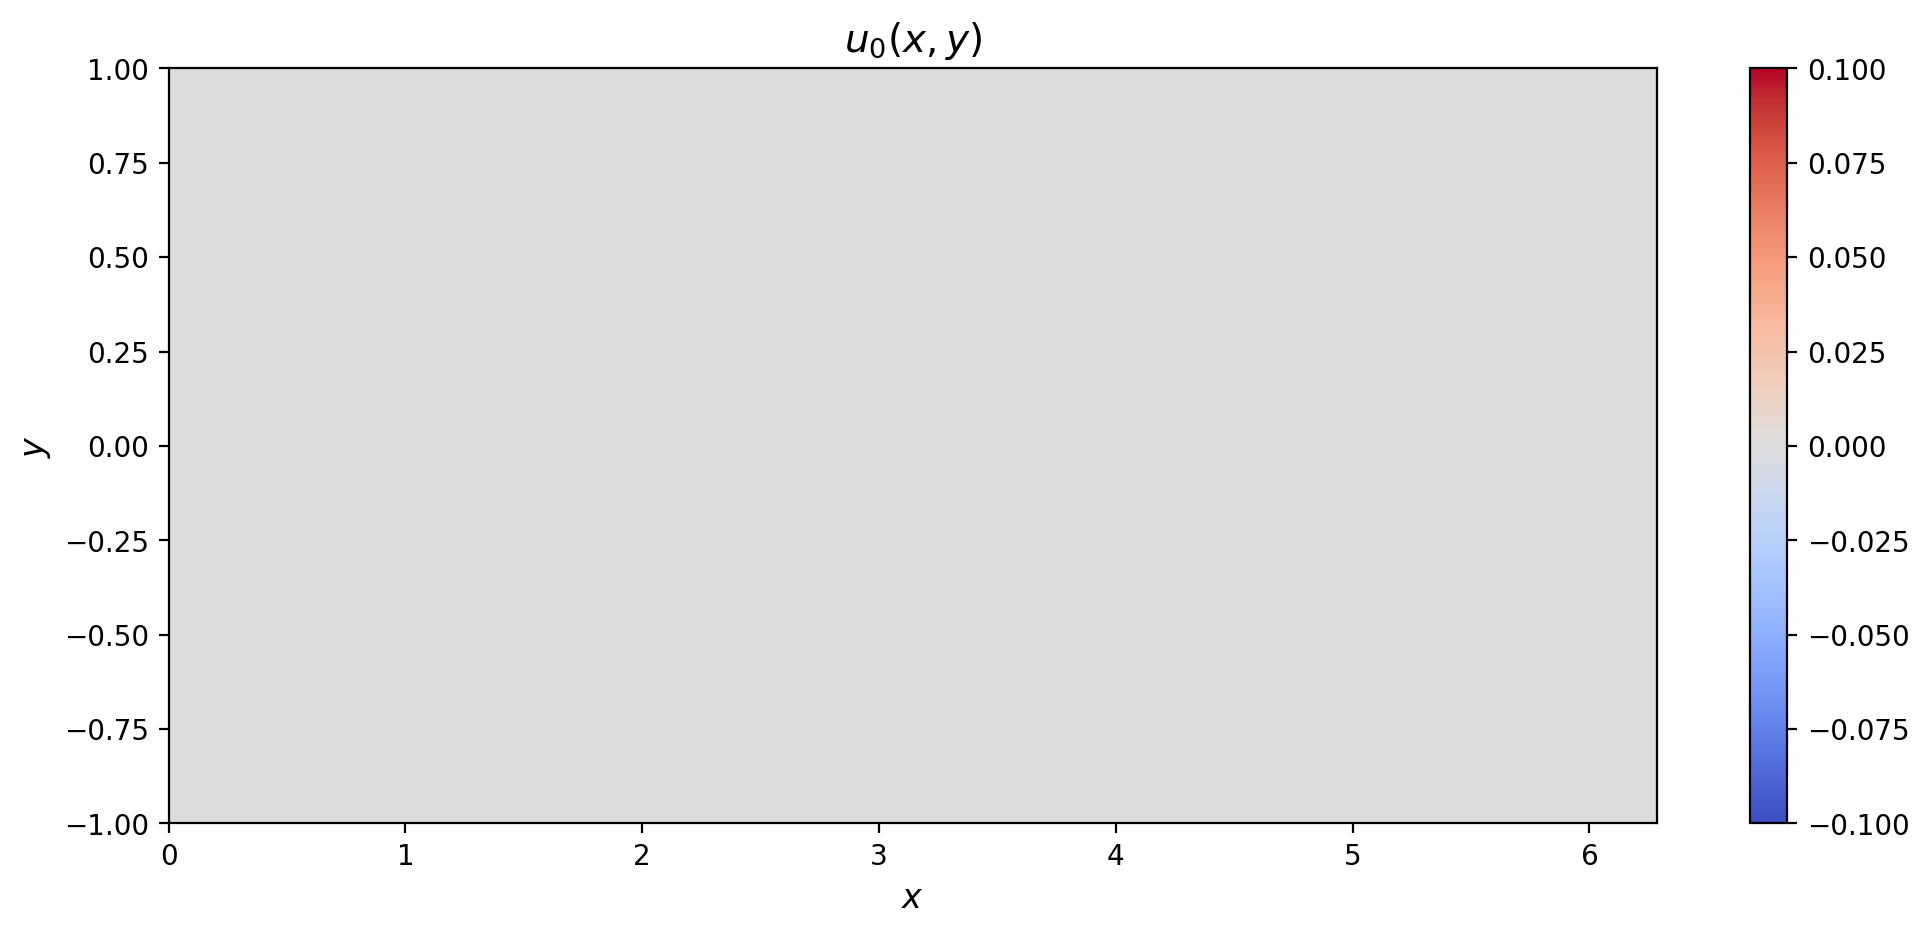

In [36]:
fig, ax = plt.subplots(figsize=(12,5),dpi=200)
u_min, u_max = Exact_u[:,:,0:1].min(), Exact_u[:,:,0:1].max()
clr = ax.pcolormesh(X[:,:,0], Y[:,:,0], Exact_u[:,:,0], cmap='coolwarm', vmin=u_min, vmax=u_max)
ax.set_title('$u_{0}(x,y)$', fontsize=14)
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$y$', fontsize=12)
ax.axis([x_0, x_1, y_0, y_1])
fig.colorbar(clr, ax=ax)
#plt.show()
plt.savefig('u_0_exp4.png',)

<ipython-input-37-b3031b33db54>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  clr = ax.pcolormesh(X[:,:,0], Y[:,:,0], f_tensor[:,:,0], cmap='coolwarm', vmin=u_min, vmax=u_max)


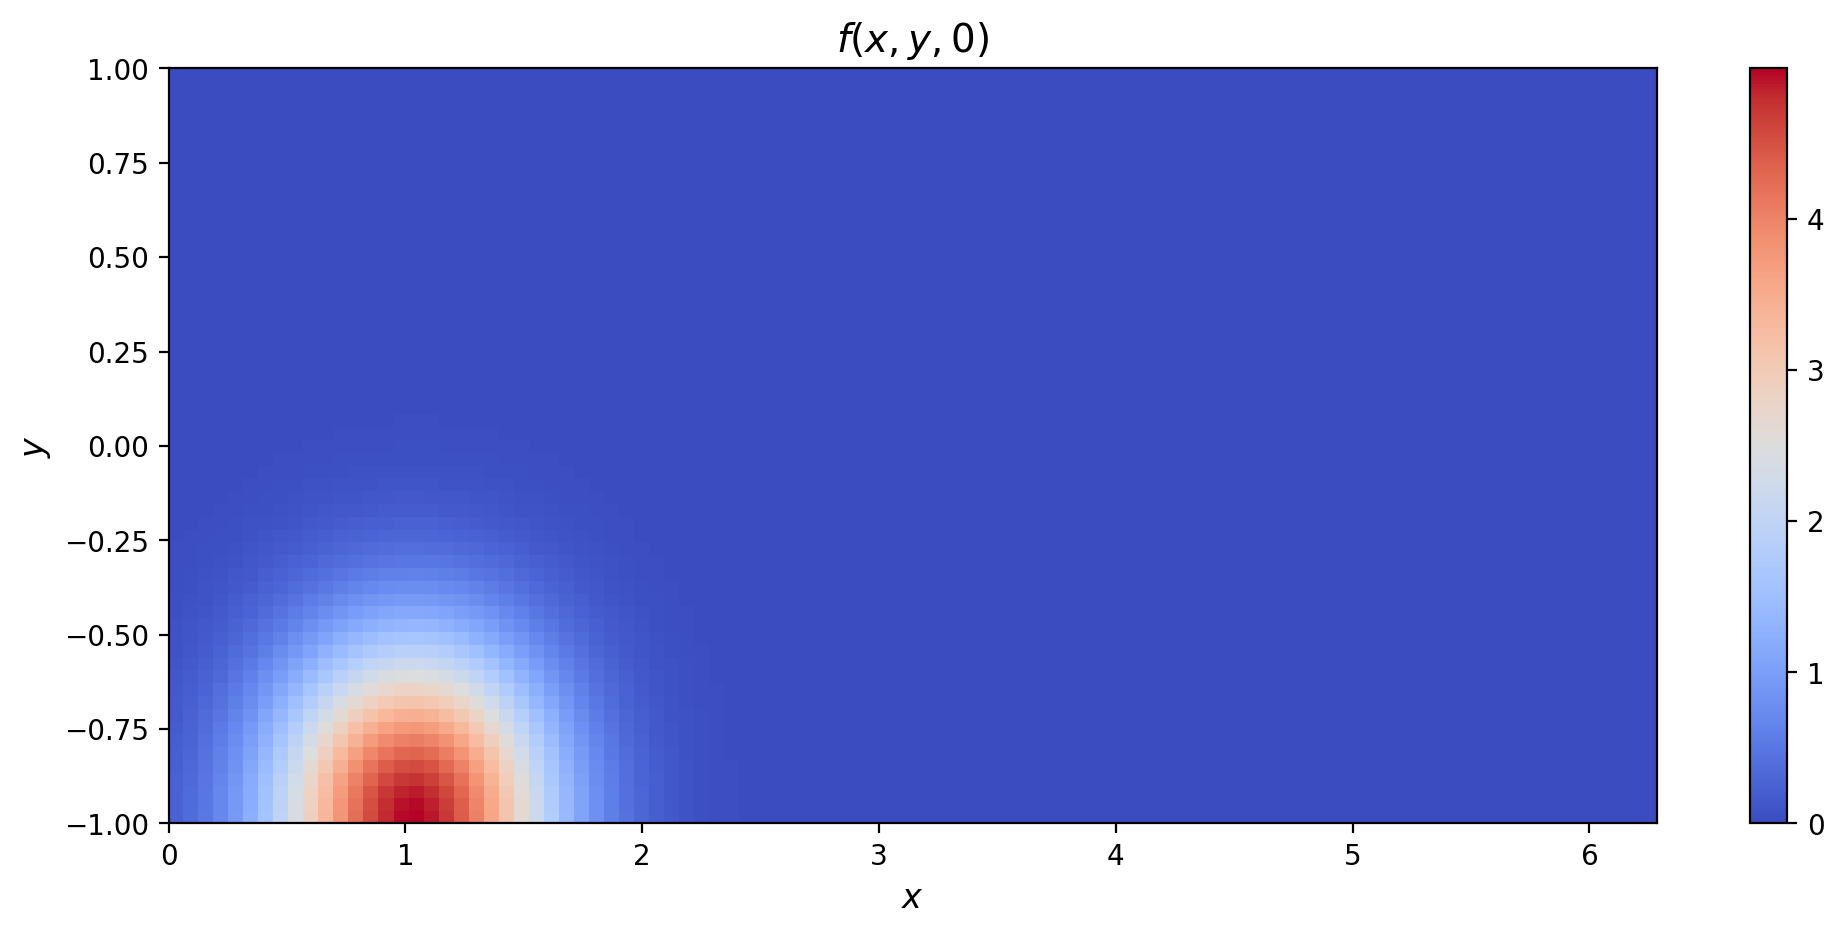

In [37]:
f_tensor = g(torch.tensor(X),torch.tensor(Y),torch.tensor(T)).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(12,5),dpi=200)
u_min, u_max = f_tensor[:,:,0:1].min(), f_tensor[:,:,0:1].max()
clr = ax.pcolormesh(X[:,:,0], Y[:,:,0], f_tensor[:,:,0], cmap='coolwarm', vmin=u_min, vmax=u_max)
ax.set_title('$f(x,y,0)$', fontsize=14)
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$y$', fontsize=12)
ax.axis([x_0, x_1, y_0, y_1])
fig.colorbar(clr, ax=ax)
#plt.show()
plt.savefig('f_0_exp4.png',)

In [38]:
import matplotlib.pyplot as plt #нужно для создания гифки
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [39]:
'''frames = [] #массив с кадрами для гифки(будут сохраняться в папку frames, нужно её создать)
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  fig, ax = plt.subplots(figsize=(12,5))
  u_min, u_max = Exact_u.min(), Exact_u.max()
  clr = ax.pcolormesh(X[:,:,current_row], Y[:,:,current_row], Exact_u[:,:,current_row], cmap='coolwarm', vmin=u_min, vmax=u_max)
  ax.set_title('$u(x,y,%.2f)$'%t, fontsize=14)
  ax.set_xlabel('$x$', fontsize=12)
  ax.set_ylabel('$y$', fontsize=12)
  ax.axis([x_0, x_1, y_0, y_1])
  fig.colorbar(clr, ax=ax)
  #plt.show() #просто показать графики
  plt.savefig('frames/u(x,y,%.2f)).png'%t) #склеить из них гифку
  plt.close()
  frame = Image.open('frames/u(x,y,%.2f)).png'%t)
  frames.append(frame)
  t+=abs(t_1-t_0)/20

frames[0].save('u(x,y,t).gif', save_all=True, append_images=frames[1:],optimize=True,duration=150,loop=0)'''

"frames = [] #массив с кадрами для гифки(будут сохраняться в папку frames, нужно её создать)\nt=t_0\nwhile t<=t_1:\n  current_row = int(t_parts*(t-t_0)/(t_1-t_0))\n  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка\n  fig, ax = plt.subplots(figsize=(12,5))\n  u_min, u_max = Exact_u.min(), Exact_u.max()\n  clr = ax.pcolormesh(X[:,:,current_row], Y[:,:,current_row], Exact_u[:,:,current_row], cmap='coolwarm', vmin=u_min, vmax=u_max)\n  ax.set_title('$u(x,y,%.2f)$'%t, fontsize=14)\n  ax.set_xlabel('$x$', fontsize=12)\n  ax.set_ylabel('$y$', fontsize=12)\n  ax.axis([x_0, x_1, y_0, y_1])\n  fig.colorbar(clr, ax=ax)\n  #plt.show() #просто показать графики\n  plt.savefig('frames/u(x,y,%.2f)).png'%t) #склеить из них гифку\n  plt.close()\n  frame = Image.open('frames/u(x,y,%.2f)).png'%t)\n  frames.append(frame)\n  t+=abs(t_1-t_0)/20\n\nframes[0].save('u(x,y,t).gif', save_all=True, append_images=frames[1:],optimize=True,duration=150,loop=0)"

Обучение

In [40]:
model = PhysicsInformedNN(X_ic_train, u_train, X_e_train, layers, lb, ub, coeff_a)

In [41]:
%%time
#штука сверху выведет итоговое время выполнения
model.train()

training started
50000 iterations of ADAM:
Iter 1000, Loss: 4.39470e-03, Loss_ic: 5.18200e-04, Loss_f: 3.41268e-03, Loss_e: 4.63822e-04
Iter 2000, Loss: 4.18724e-04, Loss_ic: 1.97425e-04, Loss_f: 2.03061e-04, Loss_e: 1.82382e-05
Iter 3000, Loss: 2.42206e-04, Loss_ic: 9.46450e-05, Loss_f: 1.32383e-04, Loss_e: 1.51778e-05
Iter 4000, Loss: 1.58648e-04, Loss_ic: 5.50870e-05, Loss_f: 9.22637e-05, Loss_e: 1.12969e-05
Iter 5000, Loss: 1.20473e-04, Loss_ic: 4.06862e-05, Loss_f: 7.03527e-05, Loss_e: 9.43407e-06
Iter 6000, Loss: 9.42635e-05, Loss_ic: 3.23881e-05, Loss_f: 5.41124e-05, Loss_e: 7.76297e-06
Iter 7000, Loss: 7.80008e-05, Loss_ic: 2.78243e-05, Loss_f: 4.35013e-05, Loss_e: 6.67513e-06
Iter 8000, Loss: 8.37942e-05, Loss_ic: 2.47860e-05, Loss_f: 5.03255e-05, Loss_e: 8.68272e-06
Iter 9000, Loss: 7.52977e-05, Loss_ic: 2.37299e-05, Loss_f: 4.54790e-05, Loss_e: 6.08877e-06
Iter 10000, Loss: 3.16736e-04, Loss_ic: 2.68292e-05, Loss_f: 2.63332e-04, Loss_e: 2.65747e-05
Iter 11000, Loss: 5.24667e

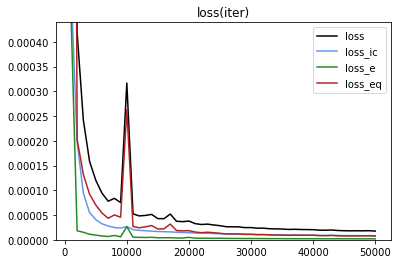

In [42]:
plt.plot(np.array(iter_array), np.array(loss_array), color = "black", label = "loss")
plt.plot(np.array(iter_array), np.array(loss_ic_array), color = "cornflowerblue", label = "loss_ic")
plt.plot(np.array(iter_array), np.array(loss_e_array), color = "forestgreen", label = "loss_e")
plt.plot(np.array(iter_array), np.array(loss_f_array), color = "firebrick", label = "loss_eq")
plt.ylim(0, np.max(loss_array)/10)
plt.title('loss(iter)')
plt.legend()
plt.show()

In [43]:
torch.save(model, 'heq_model_exp4.pth') #сохраняем модель

/opt/conda/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type DNN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/opt/conda/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type SinActivation. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [44]:
x_test = np.linspace(x_0, x_1, 2*x_parts) #берём в два раза более детальную сетку
y_test = np.linspace(y_0, y_1, 2*y_parts)
t_test = np.linspace(t_0, t_1, 2*t_parts)
X_test, Y_test, T_test = np.meshgrid(x_test, y_test, t_test)

X_ic_test = np.hstack((X_test[:,:,0].flatten()[:,None], Y_test[:,:,0].flatten()[:,None], T_test[:,:,0].flatten()[:,None]))
u_ic_test = u(X_ic_test[:,0:1], X_ic_test[:,1:2], X_ic_test[:,2:3])
X_le_test = np.hstack((X_test[:,0,:].flatten()[:,None], Y_test[:,0,:].flatten()[:,None], T_test[:,0,:].flatten()[:,None]))
X_re_test = np.hstack((X_test[:,-1,:].flatten()[:,None], Y_test[:,-1,:].flatten()[:,None], T_test[:,-1,:].flatten()[:,None]))

u_pred, f_u_pred = model.predict(X_star) #невязку смотрим по старой сетке(чтобы памяти хватило, да и всё-равно не на всей сетке учили)
u_ic_pred, f_u_ic_pred = model.predict(X_ic_test) #а всё остальное - по новой сетке
u_le_pred, f_u_le_pred = model.predict(X_le_test)
u_re_pred, f_u_re_pred = model.predict(X_re_test)
mse_u = ((u_ic_test-u_ic_pred)**2).mean().item() #точность удовлетворения начальному условию
mse_f_u = ((f_u_pred)**2).mean(axis=0).item() #точность удовлетворения условиям уравнения
mse_e_u = ((u_le_pred.reshape(2*y_parts,2*t_parts) - np.flip(u_re_pred.reshape(2*y_parts,2*t_parts),[0]))**2).mean().item() #точность сшивки правой и левой границ
mse_f_u_e = (((f_u_le_pred)**2).mean(axis=0).item() + ((f_u_re_pred)**2).mean(axis=0).item())/2 #невязка на правой и левой границах
print('MSE_u: %.3e, MSE_f_u: %.3e' %(mse_u, mse_f_u))
print('MSE_e_u: %.3e, MSE_f_u_e: %.3e' %(mse_e_u, mse_f_u_e))

MSE_u: 6.922e-06, MSE_f_u: 1.062e-05
MSE_e_u: 1.615e-06, MSE_f_u_e: 3.350e-05


Визуализация

Что выдала нейросеть:

<ipython-input-45-190e1b6577e0>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  clr = ax.pcolormesh(X[:,:,current_row], Y[:,:,current_row], u_pred.reshape((y_parts,x_parts,t_parts))[:,:,current_row], cmap='coolwarm', vmin=u_min, vmax=u_max)


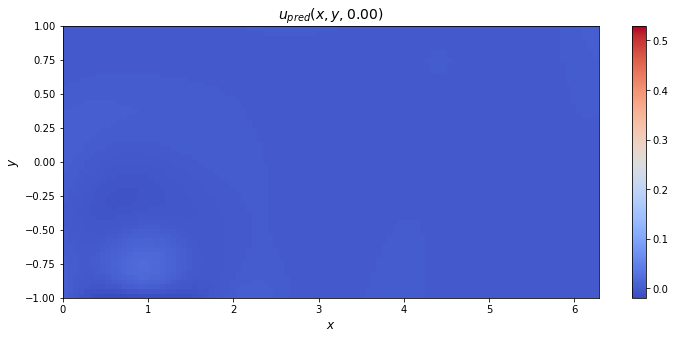

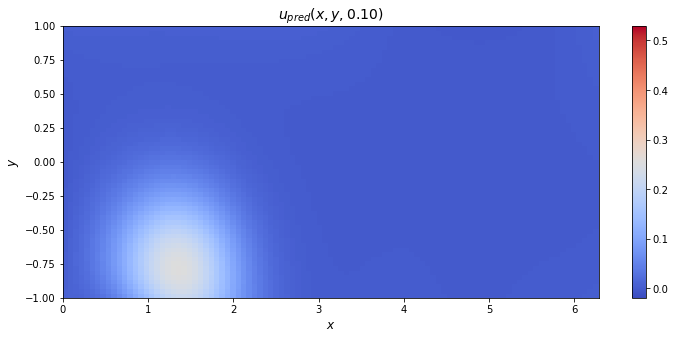

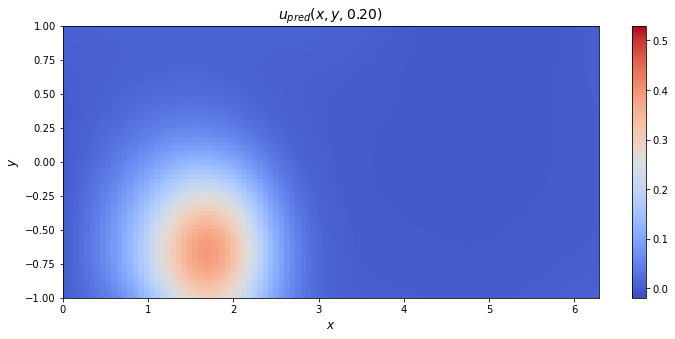

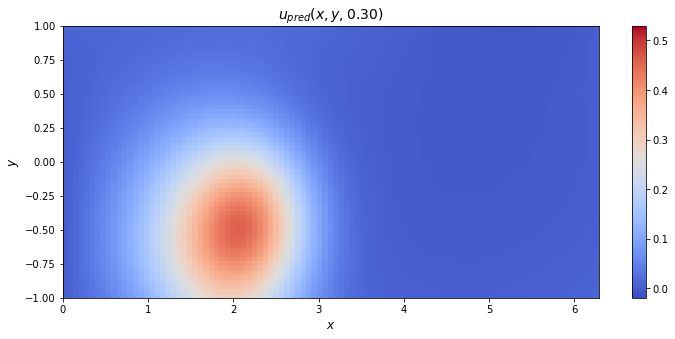

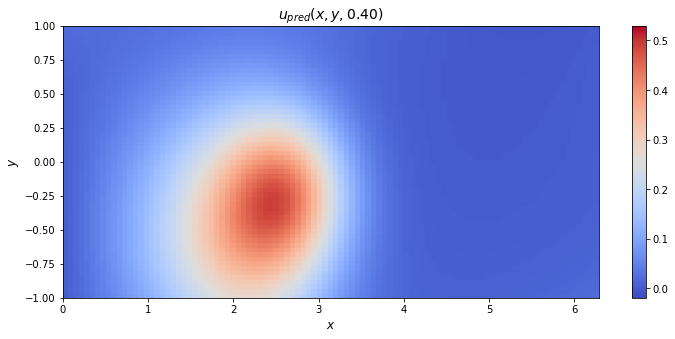

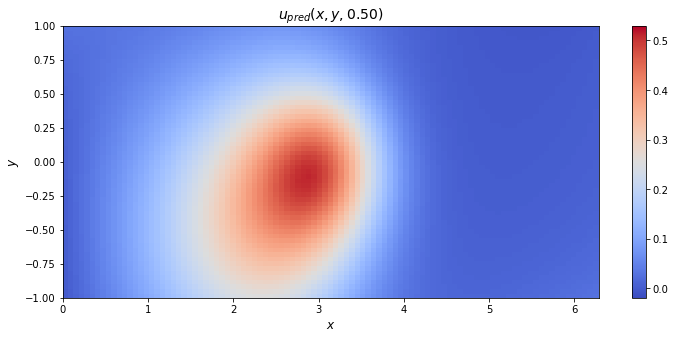

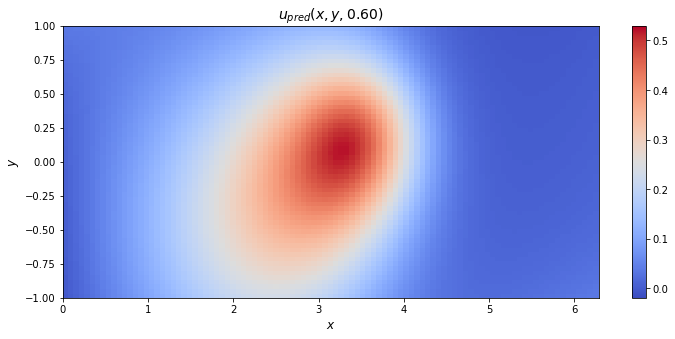

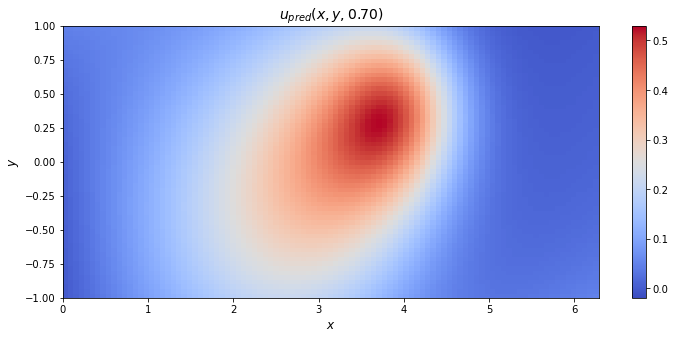

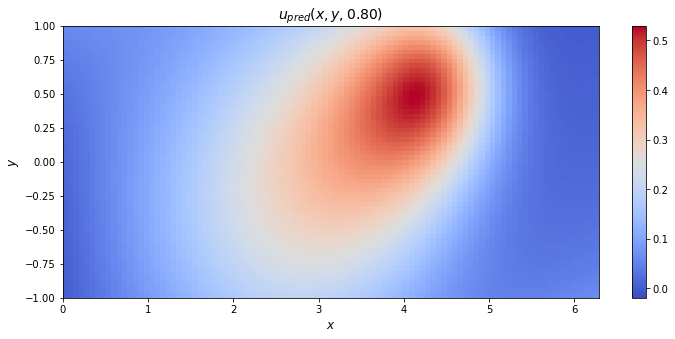

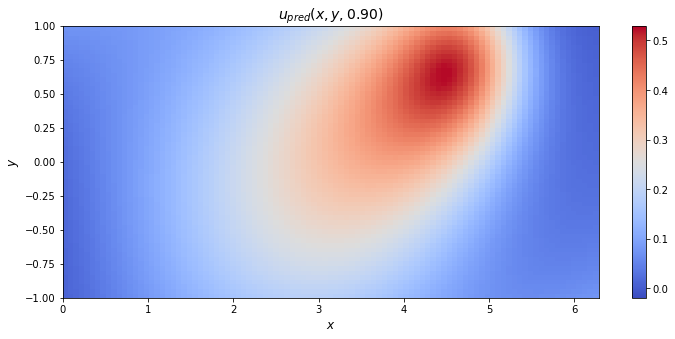

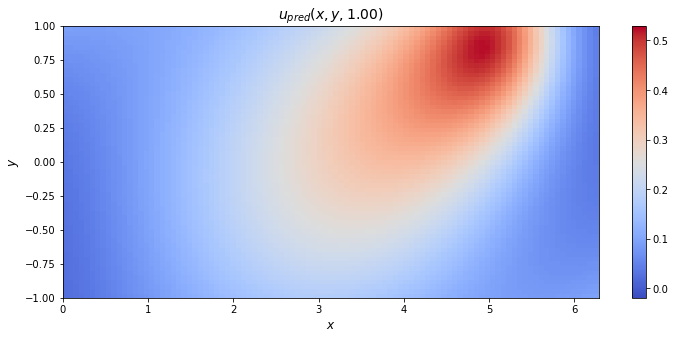

In [45]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  fig, ax = plt.subplots(figsize=(12,5))
  u_min, u_max = u_pred.min(), u_pred.max()
  clr = ax.pcolormesh(X[:,:,current_row], Y[:,:,current_row], u_pred.reshape((y_parts,x_parts,t_parts))[:,:,current_row], cmap='coolwarm', vmin=u_min, vmax=u_max)
  ax.set_title('$u_{pred}(x,y,%.2f)$'%t, fontsize=14)
  ax.set_xlabel('$x$', fontsize=12)
  ax.set_ylabel('$y$', fontsize=12)
  ax.axis([x_0, x_1, y_0, y_1])
  fig.colorbar(clr, ax=ax)
  plt.show()
  t+=abs(t_1-t_0)/10

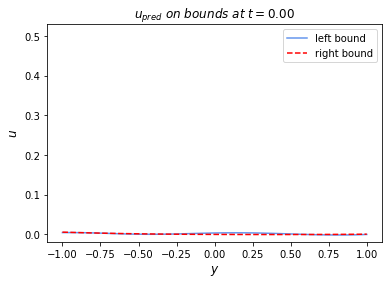

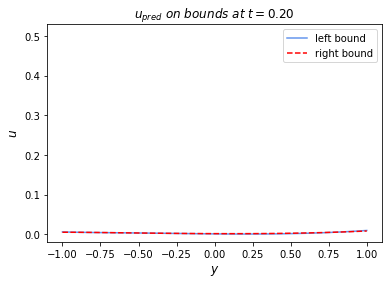

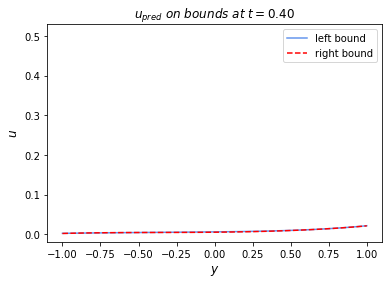

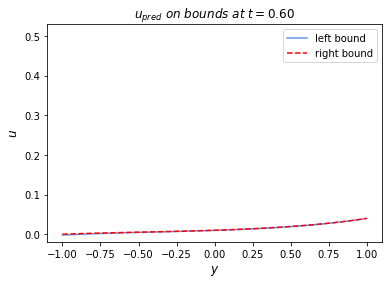

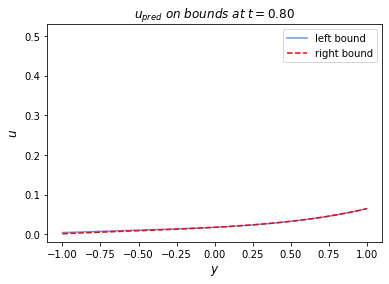

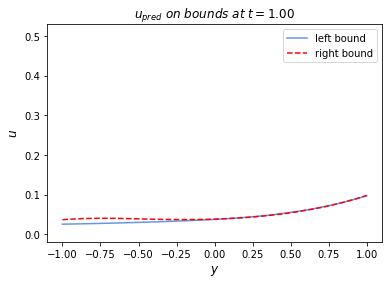

In [46]:
t=t_0
U = u_pred.reshape(y_parts,x_parts,t_parts)
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  plt.plot(Y[:,0,current_row], U[:,0,current_row], color = "cornflowerblue", label="left bound")
  plt.plot(Y[:,x_parts-1,current_row], np.flip(U[:,x_parts-1,current_row],[0]), "--r", label="right bound")
  plt.title(r'$u_{pred}\ on\ bounds\ at\ t=%.2f$'%t)
  plt.xlabel('$y$', fontsize=12)
  plt.ylabel('$u$', fontsize=12)
  plt.ylim(u_pred.min(), u_pred.max())
  plt.legend()
  plt.show()
  t+=abs(t_1-t_0)/5

<ipython-input-47-a0b5fc1840ce>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  clr = ax.pcolormesh(X[:,:,current_row], Y[:,:,current_row], f_u_pred.reshape((y_parts,x_parts,t_parts))[:,:,current_row], cmap='coolwarm', vmin=u_min, vmax=u_max)


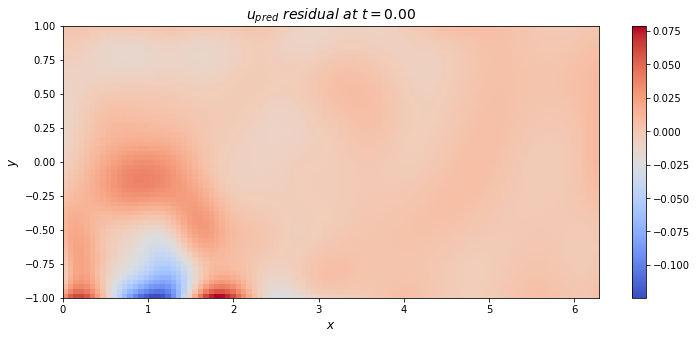

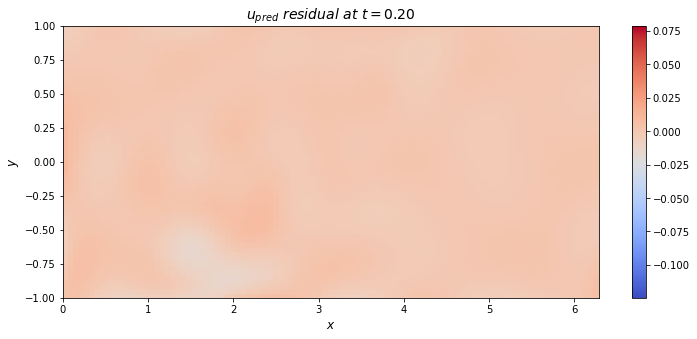

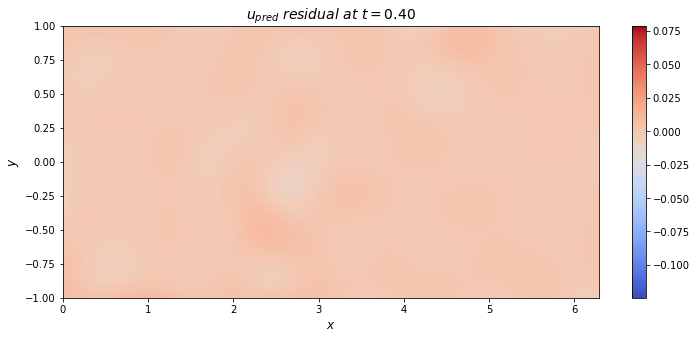

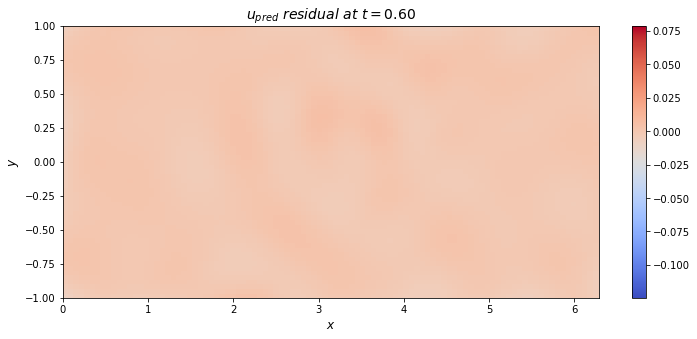

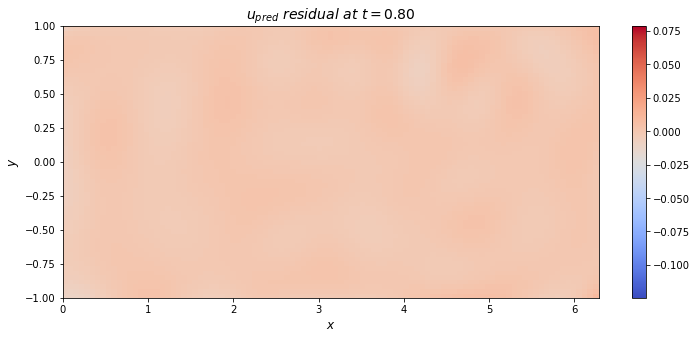

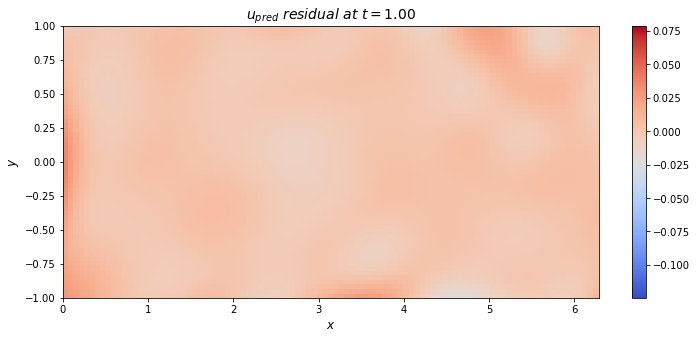

In [47]:
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1 #если смотрим значения в t_1, то ясно что это последняя колонка
  fig, ax = plt.subplots(figsize=(12,5))
  u_min, u_max = f_u_pred.min(), f_u_pred.max()
  clr = ax.pcolormesh(X[:,:,current_row], Y[:,:,current_row], f_u_pred.reshape((y_parts,x_parts,t_parts))[:,:,current_row], cmap='coolwarm', vmin=u_min, vmax=u_max)
  ax.set_title('$u_{pred}\ residual\ at\ t=%.2f$'%t, fontsize=14)
  ax.set_xlabel('$x$', fontsize=12)
  ax.set_ylabel('$y$', fontsize=12)
  ax.axis([x_0, x_1, y_0, y_1])
  fig.colorbar(clr, ax=ax)
  plt.show()
  t+=abs(t_1-t_0)/5

In [48]:
frames = []
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1
  fig, ax = plt.subplots(figsize=(12,5),dpi=200)
  u_min, u_max = u_pred.min(), u_pred.max()
  clr = ax.pcolormesh(X[:,:,current_row], Y[:,:,current_row], u_pred.reshape((y_parts,x_parts,t_parts))[:,:,current_row], cmap='coolwarm', vmin=u_min, vmax=u_max)
  ax.set_title('$u_{pred}(x,y,%.2f)$'%t, fontsize=14)
  ax.set_xlabel('$x$', fontsize=12)
  ax.set_ylabel('$y$', fontsize=12)
  ax.axis([x_0, x_1, y_0, y_1])
  fig.colorbar(clr, ax=ax)
  #plt.show() #просто показать графики
  plt.savefig('frames/u_pred_exp4(x,y,%.2f)).png'%t) #склеить из них гифку
  plt.close()
  frame = Image.open('frames/u_pred_exp4(x,y,%.2f)).png'%t)
  frames.append(frame)
  t+=abs(t_1-t_0)/20

frames[0].save('u_pred_exp4.gif', save_all=True, append_images=frames[1:],optimize=True,duration=150,loop=0)

<ipython-input-48-b64a094af4de>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  clr = ax.pcolormesh(X[:,:,current_row], Y[:,:,current_row], u_pred.reshape((y_parts,x_parts,t_parts))[:,:,current_row], cmap='coolwarm', vmin=u_min, vmax=u_max)


In [49]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


frames = []
t=t_0
while t<=t_1:
  current_row = int(t_parts*(t-t_0)/(t_1-t_0))
  if t==t_1: current_row=-1
  fig = plt.figure(dpi=200)
  ax = fig.add_subplot(111, projection='3d')

  X_current=X[:,:,current_row]
  Y_current=Y[:,:,current_row]
  U_current=u_pred.reshape((y_parts,x_parts,t_parts))[:,:,current_row]
  A = (1+0.5*Y_current*np.cos(X_current/2))*np.cos(X_current)
  B = (1+0.5*Y_current*np.cos(X_current/2))*np.sin(X_current)
  C = 0.5*Y_current*np.sin(X_current/2)

  coolwarm=plt.get_cmap('coolwarm')
  ax.set_title('$u_{pred}(x,y,%.2f)$'%t, fontsize=14)
  surf = ax.plot_surface(A, B, C, rstride=1, cstride=1, cmap=coolwarm, facecolors = coolwarm(U_current), linewidth=0)
  fig.colorbar(surf, ax=ax, pad=0.1, shrink=0.7)
  ax.set_zlim(-1.01, 1.01)
  plt.axis('off')
  #plt.show()
  plt.savefig('frames/u_pred_surface_exp4(x,y,%.2f)).png'%t) #склеить из них гифку
  plt.close()
  frame = Image.open('frames/u_pred_surface_exp4(x,y,%.2f)).png'%t)
  frames.append(frame)
  t+=abs(t_1-t_0)/20

frames[0].save('u_pred_surface_exp4.gif', save_all=True, append_images=frames[1:],optimize=True,duration=150,loop=0)